In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from operator import index
import random
import pickle
import matplotlib_inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import MultipleLocator
import sklearn.metrics

In [2]:
def euclidean_distance(X, Y):
    sum_of_squares = np.add.outer(np.sum(X ** 2, axis=1), np.sum(Y ** 2, axis=1))
    composition = np.dot(X, Y.T)
    return np.sqrt(sum_of_squares - 2 * composition)


# def cosine_distance(X, Y):
#     matrix_dot = np.dot(X, Y.T)
#     l2norms = np.sqrt(((X ** 2).sum(1)[:, None]) * ((Y ** 2).sum(1)))
#     return 1 - matrix_dot / l2norms

def cosine_distance(X, Y):
    return 1 - np.dot(X, Y.T) / (np.linalg.norm(X) * np.linalg.norm(Y))
 

In [3]:
eps = 1e-5


class KNNClassifier:
    def __init__(self, k=5, strategy='my_own', metric='euclidean', weights=False, test_block_size=20):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size
       # self.__dc, self.__d_index = None, None

    def fit(self, X_train, y_train):
        self.n_classes = len(set(y_train))  # здесь нужно доработать, если классы - строки

        if (self.strategy == 'my_own'):
            self.X_train = X_train
            self.y_train = y_train
            return self

        if (self.strategy == 'brute'):
            self.nn = NearestNeighbors(algorithm="brute", metric=self.metric, n_neighbors=self.k)

        if (self.strategy == 'kd_tree'):
            self.nn = NearestNeighbors(algorithm="kd_tree", metric="euclidean", n_neighbors=self.k)

        if (self.strategy == 'ball_tree'):
            self.nn = NearestNeighbors(algorithm="ball_tree", metric="euclidean", n_neighbors=self.k)

        self.nn.fit(X_train, y_train)
        self.X_train = X_train
        self.y_train = y_train

        return self

    def predict(self, X_test):
        return np.argmax(self.find_scores(X_test), axis=1)

    def score_custom(self, X_test, k):
        metric = {'cosine': cosine_distance, 'euclidean': euclidean_distance}
        dists = metric[self.metric](X_test, self.X_train)
        d_index = np.argpartition(dists, np.arange(1, k + 1), axis=1)[:, :k]
        d = np.partition(dists, np.arange(1, k + 1), axis=1)[:, :k]
        return d, d_index

    def find_kneighbors(self, X_test, return_distance=True):
        start_time = time.time()
        length_X = X_test.shape[0]
        N_batches = (length_X // self.test_block_size + 1) if (length_X % self.test_block_size != 0) else (
                length_X // self.test_block_size)
        distes, indexes = [], []
        for bin in range(N_batches):
            x_test = X_test[bin * self.test_block_size:min((bin + 1) * self.test_block_size, length_X)]
            if (self.strategy == 'my_own'):
                dist, ind = self.score_custom(x_test, self.k)
            else:
                dist, ind = self.nn.kneighbors(x_test, n_neighbors=self.k)
            distes.append(dist)
            indexes.append(ind)

        if not return_distance:
            return np.vstack(indexes)
        end_time = time.time()
        global work_time
        work_time = end_time - start_time
        return np.vstack(distes), np.vstack(indexes)

    def find_scores(self, x_test):
        dc, d_index = self.find_kneighbors(x_test)
        return self.voting(dc, d_index, x_test.shape[0], self.k)

    def voting(self, dc, d_index, n, k):
        votes = self.y_train[d_index]
        rez = np.zeros((n, self.n_classes))
        if (self.weights):
            weights = 1 / (dc + eps)
        else:
            weights = np.ones((n, k))

        for i in range(self.n_classes):
            rez[:, i] = ((votes == i) * weights).sum(axis=1)
        return rez

    def score(self, predicted, y_test):
        return (predicted == y_test).sum() / len(y_test)   

In [4]:
def accuracy(predicted, y_test):
    return (predicted == y_test).sum() / y_test.shape[0]


def kfold(n, n_folds=5):
    index = np.arange(n)
    block_size = n // n_folds
    cum = 0
    res = []
    for bin in range(n_folds):
        start = bin * block_size + cum
        if (bin < n % n_folds):
            cum += 1
        stop = min((bin + 1) * block_size, n) + cum
        res.append((np.hstack([index[:start], index[stop:]]), index[start:stop]))
    return res


def knn_cross_val_score(X, y, k_list, score='accuracy', cv=None, **kwargs):
    res = {}
    if cv is None:
        cv = kfold(len(X))
    for k in k_list:
        res[k] = []
    clf = KNNClassifier(k=np.max(np.array(k_list)), **kwargs)
    for train, test in cv:
        X_train, X_valid, y_train, y_valid = X[train], X[test], y[train], y[test]
        clf.fit(np.array(X_train), np.array(y_train))
        dc, d_index = clf.find_kneighbors(X_valid)
        for k in k_list:
            votes = clf.voting(dc[:, :k], d_index[:, :k], X_valid.shape[0], k)
            predicted = np.argmax(votes, axis=1)
            if score == 'accuracy':
                res[k].append(accuracy(predicted, y_valid))
    for k in k_list:
        res[k] = np.asarray(res[k])

    return res

In [30]:
mnist = fetch_openml("mnist_784")

In [29]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=10000)
X_test_array = np.array(X_test)
X_train_array = np.array(X_train)
y_test_array = np.array(y_test)
y_train_array = np.array(y_train)

NameError: name 'mnist' is not defined

In [177]:
y_test_array = np.array(list(map(int, y_test_array)))
y_train_array = np.array(list(map(int, y_train_array)))

In [178]:
np.savetxt('C:\Jupyter\prak_mmp\Experience\X_test_mnist_array.txt', X_test_array)
np.savetxt('C:\Jupyter\prak_mmp\Experience\X_train_mnist_array.txt', X_train_array)

In [179]:
np.savetxt('C:\Jupyter\prak_mmp\Experience\y_test_mnist_array.txt', np.array(list(map(int, y_test_array))))

In [180]:
np.savetxt('C:\Jupyter\prak_mmp\Experience\y_train_mnist_array.txt', np.array(list(map(int, y_train_array))))

In [5]:
X_test_array = np.loadtxt('C:\Jupyter\prak_mmp\Experience\X_test_mnist_array.txt')
X_train_array = np.loadtxt('C:\Jupyter\prak_mmp\Experience\X_train_mnist_array.txt')
y_test_array = np.loadtxt('C:\Jupyter\prak_mmp\Experience\y_test_mnist_array.txt')
y_train_array = np.loadtxt('C:\Jupyter\prak_mmp\Experience\y_train_mnist_array.txt')

### Эксперимент №1

In [8]:
list_my_own = []
list_kd_tree = []
list_brute = []
list_ball_tree = []

In [9]:
num_of_features = [10, 20, 100]

In [11]:
clf1 = KNNClassifier(k=5, strategy='my_own', metric='euclidean', weights=False, test_block_size=20)
clf2 = KNNClassifier(k=5, strategy='kd_tree', metric='euclidean', weights=False, test_block_size=20)
clf3 = KNNClassifier(k=5, strategy='ball_tree', metric='euclidean', weights=False, test_block_size=20)
clf4 = KNNClassifier(k=5, strategy='brute', metric='euclidean', weights=False, test_block_size=20)

for num in num_of_features:
    indexes = random.sample(list(np.arange(0, X_train_array.shape[1])), num)
    indexes.sort()

    clf1.fit(X_train_array[:, indexes], y_train_array)
    clf2.fit(X_train_array[:, indexes], y_train_array)
    clf3.fit(X_train_array[:, indexes], y_train_array)
    clf4.fit(X_train_array[:, indexes], y_train_array)

    predict = clf1.predict(X_test_array[:, indexes])
    list_my_own.append(work_time)

    predict = clf2.predict(X_test_array[:, indexes])
    list_kd_tree.append(work_time)

    predict = clf3.predict(X_test_array[:, indexes])
    list_ball_tree.append(work_time)

    predict = clf4.predict(X_test_array[:, indexes])
    list_brute.append(work_time)

In [12]:
my_time = {'n_features':num_of_features, 'my_own': list_my_own, 'brute': list_brute, 'kd_tree': list_kd_tree, 'ball_tree': list_ball_tree}
my_time

{'n_features': [10, 20, 100],
 'my_own': [47.38346719741821, 74.6025505065918, 64.54397630691528],
 'brute': [9.860639333724976, 10.260392427444458, 18.082817554473877],
 'kd_tree': [3.445570945739746, 16.197870016098022, 164.11362099647522],
 'ball_tree': [4.6923768520355225, 37.85926127433777, 154.64644837379456]}

In [101]:
#df = pd.DataFrame(my_time)

f = open('experiment1_df.pckl', 'rb')
df1 = pickle.load(f)
f.close()

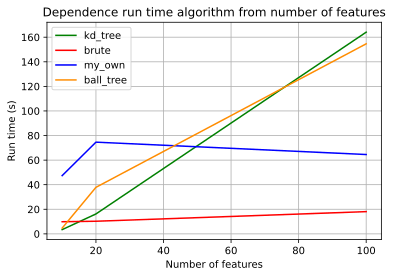

In [103]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure()
plt.xlabel("Number of features")
plt.ylabel("Run time (s)")
plt.title('Dependence run time algorithm from number of features')
plt.grid()
plt.plot(df1['n_features'], df1['kd_tree'], color = 'green', label = 'kd_tree')
plt.plot(df1['n_features'], df1['brute'], color = 'red', label = 'brute')
plt.plot(df1['n_features'], df1['my_own'], color = 'blue', label = 'my_own')
plt.plot(df1['n_features'], df1['ball_tree'], color = 'darkorange', label = 'ball_tree')
plt.legend(loc='best')
plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig('exp1.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

### Эксперимент №2

In [36]:
k_list = np.arange(1,11)
res_time = {}
res_accuracy = {}
cv_arg = kfold(X_train_array.shape[0], 3)

for metric in ['euclidean', 'cosine']:
    kwargs = {'strategy':'brute', 'metric':metric}
    start_time = time.time()
    res = knn_cross_val_score(X_train_array, y_train_array, k_list, score='accuracy', cv=cv_arg, **kwargs)
    end_time = time.time()
    work_time = end_time - start_time
    res_time[metric] = work_time
    res_accuracy[metric] = res

In [37]:
res_time

{'euclidean': 182.33409810066223, 'cosine': 942.0278644561768}

In [72]:
f = open('experiment2_res_time.pckl', 'wb')
pickle.dump(res_time, f)
f.close()

In [62]:
x = res_accuracy.copy()
for key1, value1 in x.items():
    for key2, value2 in value1.items():
        mean = value2.sum() / 3
        x[key1][key2] = mean
pickle.dump(x, f)

In [69]:
df = pd.DataFrame(x)
df['k'] = np.arange(1,11)

f = open('experiment2_df.pckl', 'wb')
pickle.dump(df, f)
f.close()

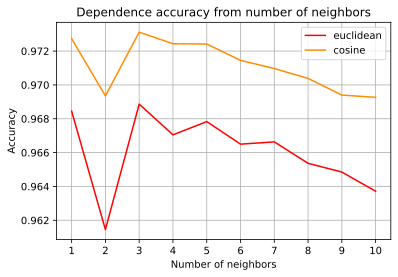

In [60]:
fig = plt.figure()
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title('Dependence accuracy from number of neighbors')
plt.grid()
plt.plot(df['k'], df['euclidean'], color = 'red', label = 'euclidean')
plt.plot(df['k'], df['cosine'], color = 'darkorange', label = 'cosine')
plt.legend(loc='best')
ax=plt.gca()
x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig('exp2.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

### Эксперимент №3

In [96]:
k_list = np.arange(1,11)
res_accuracy = {}
cv = kfold(X_train_array.shape[0], 3)

for metric in ['euclidean', 'cosine']:
    for weight in [True, False]:
        kwargs = {'strategy':'brute', 'metric':metric, 'weights':weight}
        res = knn_cross_val_score(X_train_array, y_train_array, k_list, score='accuracy', cv=cv, **kwargs)
        res_accuracy[metric + ' w=' + str(weight)] = res

In [97]:
f = open('experiment3_res.pckl', 'wb')
pickle.dump(res_accuracy, f)
f.close()

In [105]:
a = res_accuracy.copy()
for key1, value1 in a.items():
    for key2, value2 in value1.items():
        a[key1][key2] = value2.sum() / 3
# f = open('experiment3_df.pckl', 'wb')
# pickle.dump(df, f)
# f.close()
a

{'euclidean w=True': {1: 0.9684499999999999,
  2: 0.9684499999999999,
  3: 0.9699666666666666,
  4: 0.9714166666666667,
  5: 0.9691833333333334,
  6: 0.9700166666666666,
  7: 0.9682499999999999,
  8: 0.9682,
  9: 0.9664166666666668,
  10: 0.9663166666666667},
 'euclidean w=False': {1: 0.9684499999999999,
  2: 0.96145,
  3: 0.9688666666666667,
  4: 0.9670500000000001,
  5: 0.9678333333333334,
  6: 0.9664999999999999,
  7: 0.9666333333333332,
  8: 0.9653666666666666,
  9: 0.9648500000000001,
  10: 0.9637166666666666},
 'cosine w=True': {1: 0.9727333333333333,
  2: 0.9727333333333333,
  3: 0.9741333333333334,
  4: 0.9745833333333334,
  5: 0.9732666666666666,
  6: 0.9734333333333334,
  7: 0.9719333333333333,
  8: 0.9719666666666668,
  9: 0.9705333333333334,
  10: 0.97085},
 'cosine w=False': {1: 0.9727333333333333,
  2: 0.9693499999999999,
  3: 0.9731166666666665,
  4: 0.9724333333333334,
  5: 0.9724166666666667,
  6: 0.97145,
  7: 0.9709666666666666,
  8: 0.9703833333333334,
  9: 0.969399

In [109]:
df = pd.DataFrame(a)
df['k'] = np.arange(1,11)
df

,euclidean w=True,euclidean w=False,cosine w=True,cosine w=False,k
1,0.968450,0.968450,0.972733,0.972733,1
2,0.968450,0.961450,0.972733,0.969350,2
3,0.969967,0.968867,0.974133,0.973117,3
4,0.971417,0.967050,0.974583,0.972433,4
5,0.969183,0.967833,0.973267,0.972417,5
6,0.970017,0.966500,0.973433,0.971450,6
7,0.968250,0.966633,0.971933,0.970967,7
8,0.968200,0.965367,0.971967,0.970383,8
9,0.966417,0.964850,0.970533,0.969400,9
10,0.966317,0.963717,0.970850,0.969267,10


In [20]:
f = open('experiment3_df.pckl', 'rb')
df = pickle.load(f)
f.close()
df['euclidean w=True'] *= 3
df['euclidean w=False'] *= 3
df['cosine w=True'] *= 3
df['cosine w=False'] *= 3
df

,euclidean w=True,euclidean w=False,cosine w=True,cosine w=False,k
1,0.968450,0.968450,0.972733,0.972733,1
2,0.968450,0.961450,0.972733,0.969350,2
3,0.969967,0.968867,0.974133,0.973117,3
4,0.971417,0.967050,0.974583,0.972433,4
5,0.969183,0.967833,0.973267,0.972417,5
6,0.970017,0.966500,0.973433,0.971450,6
7,0.968250,0.966633,0.971933,0.970967,7
8,0.968200,0.965367,0.971967,0.970383,8
9,0.966417,0.964850,0.970533,0.969400,9
10,0.966317,0.963717,0.970850,0.969267,10


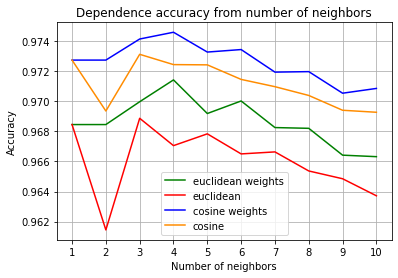

In [21]:
fig = plt.figure()
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title('Dependence accuracy from number of neighbors')
plt.grid()
plt.plot(df['k'], df['euclidean w=True'], color = 'green', label = 'euclidean weights')
plt.plot(df['k'], df['euclidean w=False'], color = 'red', label = 'euclidean')
plt.plot(df['k'], df['cosine w=True'], color = 'blue', label = 'cosine weights')
plt.plot(df['k'], df['cosine w=False'], color = 'darkorange', label = 'cosine')
plt.legend(loc='best')
ax=plt.gca()
x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.show()
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
fig.savefig('exp3.pdf', transparent=True, facecolor = 'white', bbox_inches = 'tight')

### Эксперимент №4

In [22]:
f = open('experiment3_res.pckl', 'rb')
res_accuracy = pickle.load(f)
f.close()
res_accuracy

{'euclidean w=True': {1: array([0.969  , 0.967  , 0.96935]),
  2: array([0.969  , 0.967  , 0.96935]),
  3: array([0.97185, 0.9683 , 0.96975]),
  4: array([0.9728 , 0.9701 , 0.97135]),
  5: array([0.97105, 0.96715, 0.96935]),
  6: array([0.97105, 0.96825, 0.97075]),
  7: array([0.9699 , 0.96595, 0.9689 ]),
  8: array([0.96975, 0.9659 , 0.96895]),
  9: array([0.96785, 0.9639 , 0.9675 ]),
  10: array([0.9678 , 0.96325, 0.9679 ])},
 'euclidean w=False': {1: array([0.969  , 0.967  , 0.96935]),
  2: array([0.96335, 0.9609 , 0.9601 ]),
  3: array([0.9708, 0.9673, 0.9685]),
  4: array([0.9683 , 0.96625, 0.9666 ]),
  5: array([0.97   , 0.96575, 0.96775]),
  6: array([0.96865, 0.9638 , 0.96705]),
  7: array([0.96835, 0.9644 , 0.96715]),
  8: array([0.9674, 0.9627, 0.966 ]),
  9: array([0.9671 , 0.9616 , 0.96585]),
  10: array([0.96565, 0.96065, 0.96485])},
 'cosine w=True': {1: array([0.9736, 0.9702, 0.9744]),
  2: array([0.9736, 0.9702, 0.9744]),
  3: array([0.97515, 0.9716 , 0.97565]),
  4: ar

In [38]:
clf = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=20)
clf.fit(X_train_array, y_train_array)
predict4 = clf.predict(X_test_array)

In [39]:
precision = clf.score(predict4, y_test_array)
precision

0.979

In [40]:
res = knn_cross_val_score(X_train_array, y_train_array, [3], score='accuracy', cv=None, **kwargs)
print('accuracy for CV: ', res)

accuracy for CV:  {3: array([0.9755    , 0.97558333, 0.97233333, 0.97558333, 0.975     ])}


In [6]:
import seaborn as sns

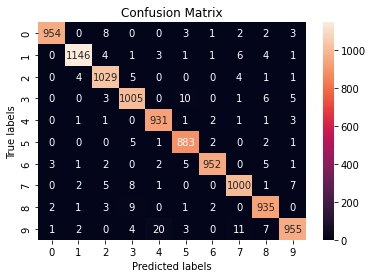

In [29]:
cm = sklearn.metrics.confusion_matrix(predict4, y_test_array)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('confusion_matrix.pdf')

In [27]:
n = 0
i = 0
errors = []
real = []
while n < 6:
    if predict4[i] != y_test_array[i]:
        errors.append(X_test_array[i])
        real.append(y_test_array[i])
        n += 1
    i += 1

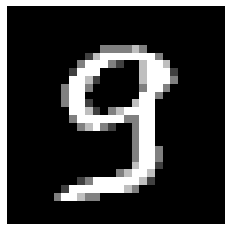

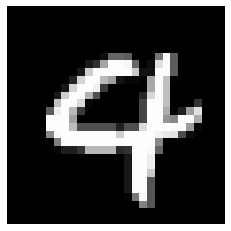

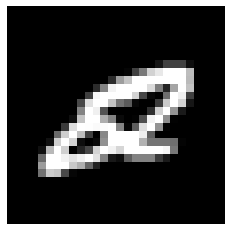

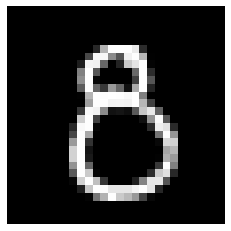

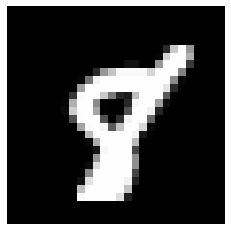

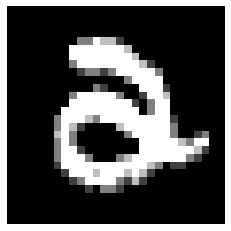

9.0
4.0
2.0
8.0
8.0
2.0


In [28]:
for err in errors:
    image = np.array(err, dtype='float')
    pixels = image.reshape((28, 28))
    plt.axis('off')
    plt.imshow(pixels, cmap='gray')
    plt.show()
for num in real:
    print(num)

### Эксперимент №5

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.transform
import scipy.ndimage
import cv2 as cv
import PIL
%matplotlib inline

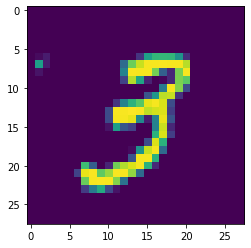

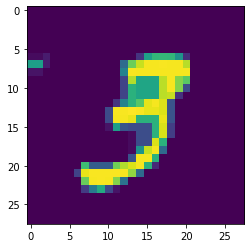

In [8]:
import copy
import scipy
import cv2 as cv

image = X_test_array[2].reshape((28, 28))
plt.imshow(image)
plt.show()
kernel = np.ones((3,3),np.uint8)
closing = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.show()

In [ ]:
dig = X_test_array[0].reshape((28, 28))
plt.imshow(dig)
plt.show()
rotated_image = skimage.transform.rotate(dig, -30) 
plt.imshow(rotated_image)
plt.show()
# pixels = image.reshape((28, 28))

In [84]:
# x = copy.deepcopy(X_train_array[0])

# x = np.reshape(x, (28,28))
# x = np.reshape(x, (784))
# x.shape
a = np.zeros([2, 4])
for elem in a:
    b = np.reshape(elem, (4, 1))
    b = [1, 1, 1, 1]
    elem = np.reshape(b, (4))
a

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [88]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
   image = np.reshape(augmentation[i], (28, 28))
   rotated_image = skimage.transform.rotate(image, 5)
   augmentation[i] = np.reshape(rotated_image, (784))

In [110]:
union = np.vstack([X_train_array, augmentation])
union.shape

(120000, 784)

In [122]:
rotate_accuracy = {}
union_target = np.hstack([y_train_array, y_train_array])
union_target.shape

(120000,)

In [123]:
k_list = [3]
kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
cv = kfold(union.shape[0], 3)
res = knn_cross_val_score(union, union_target, k_list, score='accuracy', cv=cv, **kwargs)
rotate_accuracy['5 degree'] = res

In [129]:
rotate_accuracy

{'5 degree': {3: array([0.997975, 0.99775 , 0.9968  ])}}

In [ ]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
   image = np.reshape(augmentation[i], (28, 28))
   rotated_image = skimage.transform.rotate(image, -5)
   augmentation[i] = np.reshape(rotated_image, (784)) 

union = np.vstack([X_train_array, augmentation])
union_target = np.hstack([y_train_array, y_train_array])

In [ ]:
k_list = [3]
kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
cv = kfold(union.shape[0], 3)
res = knn_cross_val_score(union, union_target, k_list, score='accuracy', cv=cv, **kwargs)
rotate_accuracy['-5 degree'] = res

In [116]:
k_list = [3]
for i 

(120000,)

In [11]:
import scipy as sp

In [10]:
shift_accuracy = {}
k_list = [3]

In [12]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [2, 0])
    augmentation[i] = np.reshape(shifted_image, (784)) 

union = np.vstack([X_train_array, augmentation])
union_target = np.hstack([y_train_array, y_train_array])

kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
cv = kfold(union.shape[0], 3)
res = knn_cross_val_score(union, union_target, k_list, score='accuracy', cv=cv, **kwargs)
shift_accuracy['shift 2 right'] = res
shift_accuracy

{'shift 2 right': {3: array([0.96755, 0.9762 , 0.9676 ])}}

In [13]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [0, 1])
    augmentation[i] = np.reshape(shifted_image, (784)) 

union = np.vstack([X_train_array, augmentation])
union_target = np.hstack([y_train_array, y_train_array])

kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
cv = kfold(union.shape[0], 3)
res = knn_cross_val_score(union, union_target, k_list, score='accuracy', cv=cv, **kwargs)
shift_accuracy['shift 1 up'] = res
shift_accuracy

{'shift 2 right': {3: array([0.96755, 0.9762 , 0.9676 ])},
 'shift 1 up': {3: array([0.982075, 0.983625, 0.981475])}}

In [14]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [0, 3])
    augmentation[i] = np.reshape(shifted_image, (784)) 

union = np.vstack([X_train_array, augmentation])
union_target = np.hstack([y_train_array, y_train_array])

kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
cv = kfold(union.shape[0], 3)
res = knn_cross_val_score(union, union_target, k_list, score='accuracy', cv=cv, **kwargs)
shift_accuracy['shift 3 up'] = res
shift_accuracy

{'shift 2 right': {3: array([0.96755, 0.9762 , 0.9676 ])},
 'shift 1 up': {3: array([0.982075, 0.983625, 0.981475])},
 'shift 3 up': {3: array([0.96615 , 0.975425, 0.9674  ])}}

In [15]:
gausse_accuracy = {}

In [17]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    gausse_image = cv.GaussianBlur(image, (3, 3), 1)
    augmentation[i] = np.reshape(gausse_image, (784)) 

union = np.vstack([X_train_array, augmentation])
union_target = np.hstack([y_train_array, y_train_array])

k_list = [3]
kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
cv_arg = kfold(union.shape[0], 3)
res = knn_cross_val_score(union, union_target, k_list, score='accuracy', cv=cv_arg, **kwargs)
gausse_accuracy['dispersion = 1'] = res
gausse_accuracy

{'dispersion = 1': {3: array([0.9998  , 0.998175, 0.99655 ])}}

In [33]:
gausse_accuracy = {}

In [34]:
def cross_validation(X, y, k_neib, disp, score='accuracy', cv_arg=None, **kwargs):
    res = []
    if cv_arg is None:
        cv_arg = kfold(len(X), n_folds = 3)
    clf = KNNClassifier(k=k_neib, **kwargs)
    for train, test in cv_arg:
        X_train, X_valid, y_train, y_valid = X[train], X[test], y[train], y[test]
        augmentation = copy.deepcopy(X_train)
        for i in range(augmentation.shape[0]):
            image = np.reshape(augmentation[i], (28, 28))
            gausse_image = cv.GaussianBlur(image, (3, 3), disp)
            augmentation[i] = np.reshape(gausse_image, (784)) 
        X_train = np.vstack([X_train, augmentation])
        y_train = np.hstack([y_train, y_train])
        clf.fit(np.array(X_train), np.array(y_train))
        dc, d_index = clf.find_kneighbors(X_valid)
        votes = clf.voting(dc[:, :k_neib], d_index[:, :k_neib], X_valid.shape[0], k_neib)
        predicted = np.argmax(votes, axis=1)
        if score == 'accuracy':
            res.append(accuracy(predicted, y_valid))
    return res

In [35]:
kwargs = {'strategy':'brute', 'metric':'cosine', 'weights':True}
res = cross_validation(X_train_array, y_train_array, k_neib=3, disp=0.5, score='accuracy', **kwargs)
gausse_accuracy['dispersion = 0.5'] = res
print(gausse_accuracy)
res = cross_validation(X_train_array, y_train_array, k_neib=3, disp=1, score='accuracy', **kwargs)
gausse_accuracy['dispersion = 1'] = res
print(gausse_accuracy)
res = cross_validation(X_train_array, y_train_array, k_neib=3, disp=1.5, score='accuracy', **kwargs)
gausse_accuracy['dispersion = 1.5'] = res
print(gausse_accuracy)

{'dispersion = 0.5': [0.9767, 0.9729, 0.9776]}
{'dispersion = 0.5': [0.9767, 0.9729, 0.9776], 'dispersion = 1': [0.97995, 0.9772, 0.98035]}
{'dispersion = 0.5': [0.9767, 0.9729, 0.9776], 'dispersion = 1': [0.97995, 0.9772, 0.98035], 'dispersion = 1.5': [0.9808, 0.9773, 0.9803]}


In [83]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, 10)
    augmentation[i] = np.reshape(rotated_image, (784))

X_train = np.vstack([X_train_array, augmentation])
y_train = np.hstack([y_train_array, y_train_array])

clf = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=20)
clf.fit(X_train, y_train)
pred5 = clf.predict(X_test_array)

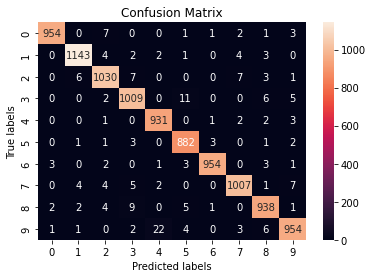

In [84]:
cm = sklearn.metrics.confusion_matrix(pred5, y_test_array)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('confusion_matrix5-1.pdf')

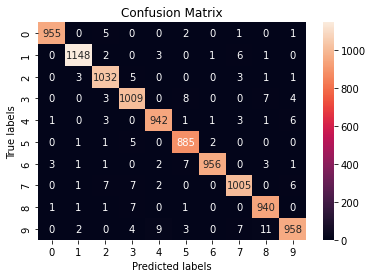

In [85]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    gausse_image = cv.GaussianBlur(image, (3, 3), 1.5)
    augmentation[i] = np.reshape(gausse_image, (784)) 

X_train = np.vstack([X_train_array, augmentation])
y_train = np.hstack([y_train_array, y_train_array])

clf = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=20)
clf.fit(X_train, y_train)
pred52 = clf.predict(X_test_array)
cm = sklearn.metrics.confusion_matrix(pred52, y_test_array)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('confusion_matrix5-2.pdf')

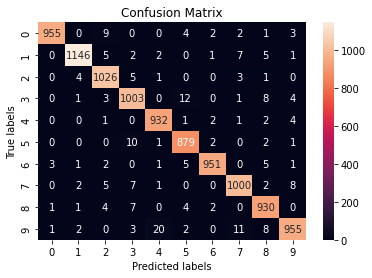

In [87]:
augmentation = copy.deepcopy(X_train_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    augmentation[i] = np.reshape(opening, (784)) 

X_train = np.vstack([X_train_array, augmentation])
y_train = np.hstack([y_train_array, y_train_array])

clf = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=20)
clf.fit(X_train, y_train)
pred53 = clf.predict(X_test_array)
cm = sklearn.metrics.confusion_matrix(pred53, y_test_array)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('confusion_matrix5-3.pdf')

In [86]:
print(accuracy(pred52, y_test_array))

0.983


### Эксперимент 6

In [42]:
big_struct = [X_test_array]

In [43]:
augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    kernel = np.ones((3,3),np.uint8)
    closing = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    augmentation[i] = np.reshape(closing, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    augmentation[i] = np.reshape(opening, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    kernel = np.ones((2,2),np.uint8)
    erosion = cv.erode(image,kernel,iterations = 1)
    augmentation[i] = np.reshape(erosion, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    kernel = np.ones((3,3),np.uint8)
    dilation = cv.dilate(image,kernel,iterations = 1)
    augmentation[i] = np.reshape(dilation, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [1, 0])
    augmentation[i] = np.reshape(shifted_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [2, 0])
    augmentation[i] = np.reshape(shifted_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [3, 0])
    augmentation[i] = np.reshape(shifted_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [0, 1])
    augmentation[i] = np.reshape(shifted_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [0, 2])
    augmentation[i] = np.reshape(shifted_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    shifted_image = sp.ndimage.shift(image, [0, 3])
    augmentation[i] = np.reshape(shifted_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, 5)
    augmentation[i] = np.reshape(rotated_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, -5)
    augmentation[i] = np.reshape(rotated_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, 10)
    augmentation[i] = np.reshape(rotated_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, -10)
    augmentation[i] = np.reshape(rotated_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, 15)
    augmentation[i] = np.reshape(rotated_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    rotated_image = skimage.transform.rotate(image, -15)
    augmentation[i] = np.reshape(rotated_image, (784))
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    gausse_image = cv.GaussianBlur(image, (3, 3), 0.5)
    augmentation[i] = np.reshape(gausse_image, (784)) 
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    gausse_image = cv.GaussianBlur(image, (3, 3), 1)
    augmentation[i] = np.reshape(gausse_image, (784)) 
big_struct.append(augmentation)

augmentation = copy.deepcopy(X_test_array)
for i in range(augmentation.shape[0]):
    image = np.reshape(augmentation[i], (28, 28))
    gausse_image = cv.GaussianBlur(image, (3, 3), 1.5)
    augmentation[i] = np.reshape(gausse_image, (784)) 
big_struct.append(augmentation)

In [70]:
big_struct = np.array(big_struct)

In [72]:
big_struct.shape

(20, 10000, 784)

In [74]:
big_predict = []
clf = KNNClassifier(k=3, strategy='brute', metric='cosine', weights=True, test_block_size=20)
clf.fit(X_train_array, y_train_array)

for i in range(20):
    big_predict.append(clf.predict(big_struct[i]))

In [90]:
np.savetxt('C:\Jupyter\prak_mmp\Experience\predict6.txt', big_predict)

In [78]:
big_predict = np.array(big_predict)
big_predict = big_predict.astype(int)
big_predict.T

array([[0, 0, 0, ..., 0, 0, 0],
       [4, 4, 4, ..., 4, 4, 4],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [8, 8, 1, ..., 8, 8, 8],
       [0, 0, 0, ..., 0, 0, 0]])

In [81]:
pred = []
for elem in big_predict.T:
    pred.append(np.argmax(np.bincount(elem)))
print(accuracy(pred, y_test_array))

0.9801


In [ ]:
res_predict = np.array([])
big_predict = big_predict.T
for i in range(len(big_predict[0])):
    res_predict.append(most_frequent(list(big_predict[i])))

In [66]:
def most_frequent(List):
    return max(set(List), key = List.count)

In [58]:
a = np.array([1,2,3,1,2,1,1,1,3,2,2,1])
print(a)
counts = np.bincount(a)
print(np.argmax(counts))

[1 2 3 1 2 1 1 1 3 2 2 1]
1


In [91]:
predict6 = np.loadtxt('C:\Jupyter\prak_mmp\Experience\predict6.txt')

In [96]:
for i in range(20):
    print(i+1,') ', accuracy(predict6[i], y_test_array))

1 )  0.979
2 )  0.9685
3 )  0.8879
4 )  0.9475
5 )  0.9037
6 )  0.9579
7 )  0.836
8 )  0.5523
9 )  0.9522
10 )  0.7859
11 )  0.5947
12 )  0.9769
13 )  0.9749
14 )  0.9666
15 )  0.9679
16 )  0.9441
17 )  0.948
18 )  0.9775
19 )  0.9739
20 )  0.9734


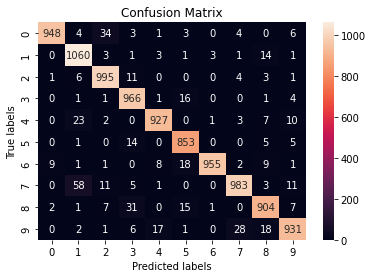

In [97]:
cm = sklearn.metrics.confusion_matrix(predict6[8], y_test_array)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('confusion_matrix6-8.pdf')

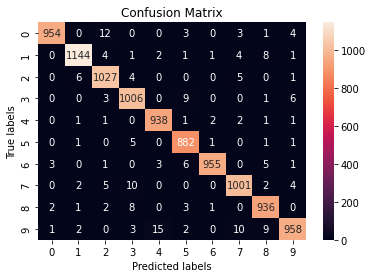

In [99]:
cm = sklearn.metrics.confusion_matrix(pred, y_test_array)
fig = plt.figure()
ax=plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
fig.savefig('confusion_matrix6-m.pdf')